In [ ]:
import torch
import os
import random
import json
import utils
import data_utils
import cbm
import plots
from IPython.display import display
from PIL import Image
# 11/23 인증오류
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import torch
import os
# 11/23 인증오류


In [ ]:


load_dir = "saved_models/eurosat_rgb_cbm_2025_11_23_01_23" 

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# args.txt 로드
args_path = os.path.join(load_dir, "args.txt")
with open(args_path, "r") as f:
    args = json.load(f)

print(f"Loaded args from: {args_path}")
dataset = args["dataset"]

# RemoteCLIP과 일반 CLIP 처리 전처리기 로드
if args["backbone"] == 'remote_clip_vit_b_32':
    print("--- Loading RemoteCLIP Preprocess ---")
    remote_clip_path = args.get("remote_clip_path")
    if not remote_clip_path:     
        raise ValueError("args.txt에 'remote_clip_path'가 없습니다. 모델 경로를 확인해주세요.")
    
    # utils.py의 함수
    _, target_preprocess = utils.load_remote_clip(
        args.get("clip_name", "ViT-B-32"), 
        remote_clip_path, 
        device
    )
else: # 일반 CLIP은 여기
    print(f"--- Loading Standard Preprocess for {args['backbone']} ---")
    _, target_preprocess = data_utils.get_target_model(args["backbone"], device)

# 모델 로드 
print("--- Loading CBM Model ---")
model = cbm.load_cbm(load_dir, device)
print("Model loaded successfully.")

Using device: cpu
Loaded args from: saved_models/eurosat_rgb_cbm_2025_11_23_01_23\args.txt
--- Loading Standard Preprocess for clip_ViT-B/32 ---
--- Loading CBM Model ---
Model loaded successfully.


In [ ]:
val_d_probe = dataset + "_val"
cls_file = data_utils.LABEL_FILES[dataset]

# Tensor 데이터 (모델 입력용)
val_data_t = data_utils.get_data(val_d_probe, preprocess=target_preprocess)
# PIL 데이터 (시각화용 원본 이미지)
val_pil_data = data_utils.get_data(val_d_probe)

In [17]:
with open(cls_file, "r") as f:
    classes = f.read().split("\n")

with open(os.path.join(load_dir, "concepts.txt"), "r") as f:
    concepts = f.read().split("\n")

## Measure accuracy

In [ ]:
print("Calculating Accuracy...")
accuracy = utils.get_accuracy_cbm(model, val_data_t, device)
print("Validation Accuracy: {:.2f}%".format(accuracy*100))

Calculating Accuracy...


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [03:54<00:00, 10.65s/it]

Validation Accuracy: 92.74%


## Show final layer weights for some classes

You can build a Sankey diagram of weights by copying the incoming weights printed below into https://sankeymatic.com/build/

In [ ]:

# 모델 가중치

print("\n=== Global Concept Importance (Top 5 & Bottom 5) ===")
top_weights, top_weight_ids = torch.topk(model.final.weight, k=5, dim=1)
bottom_weights, bottom_weight_ids = torch.topk(model.final.weight, k=5, dim=1, largest=False)

# 상위 5개 클래스만
for i in range(min(5, len(classes))):
    print(f"Class {i} - {classes[i]}")
    
    # 긍정 기여
    out_high = "  [+] Highest: "
    for j in range(top_weights.shape[1]):
        idx = int(top_weight_ids[i, j].cpu())
        out_high += "{}:{:.3f}, ".format(concepts[idx], top_weights[i, j])
    print(out_high)
    
    # 부정 기여
    out_low = "  [-] Lowest : "
    for j in range(bottom_weights.shape[1]):
        idx = int(bottom_weight_ids[i, j].cpu())
        out_low += "{}:{:.3f}, ".format(concepts[idx], bottom_weights[i, j])
    print(out_low + "\n")


=== Global Concept Importance (Top 5 & Bottom 5) ===
Class 0 - AnnualCrop
  [+] Highest: geometric shapes:1.641, a pier or dock:1.201, smooth texture:1.052, plowed soil lines:0.992, arid region:0.849, 
  [-] Lowest : glacier:-1.039, uneven terrain:-0.984, deep blue water:-0.858, square outline:-0.745, a rock formation:-0.737, 

Class 1 - Forest
  [+] Highest: rectangular shape:1.963, deep blue water:1.922, helipad:1.311, plowed soil lines:1.280, a mountain or hill:1.261, 
  [-] Lowest : arid region:-1.663, patchwork layout:-1.637, sharp angles:-1.597, bare soil or dirt:-1.133, snow or ice:-1.016, 

Class 2 - HerbaceousVegetation
  [+] Highest: winding path:1.407, water ripples:1.304, glacier:0.952, straight line:0.914, an isolated object:0.851, 
  [-] Lowest : long and narrow object:-1.272, low density:-1.005, smooth texture:-0.933, a cultivated field:-0.793, curved pattern:-0.684, 

Class 3 - Highway
  [+] Highest: sharp angles:1.494, a roundabout:1.276, a greenhouse:0.875, a bridge:

In [20]:
to_show = random.choices([i for i in range(len(classes))], k=2)

top_weights, top_weight_ids = torch.topk(model.final.weight, k=5, dim=1)
bottom_weights, bottom_weight_ids = torch.topk(model.final.weight, k=5, dim=1, largest=False)

#for i in to_show:
for i in range(0,10):
    print("Class {} - {}".format(i, classes[i]))
    out = "Highest weights: "
    for j in range(top_weights.shape[1]):
        idx = int(top_weight_ids[i, j].cpu())
        out += "{}:{:.3f}, ".format(concepts[idx], top_weights[i, j])
    print(out)
    out = "Lowest weights: "
    for j in range(bottom_weights.shape[1]):
        idx = int(bottom_weight_ids[i, j].cpu())
        out += "{}:{:.3f}, ".format(concepts[idx], bottom_weights[i, j])
    print(out + "\n")

Class 0 - AnnualCrop
Highest weights: geometric shapes:1.641, a pier or dock:1.201, smooth texture:1.052, plowed soil lines:0.992, arid region:0.849, 
Lowest weights: glacier:-1.039, uneven terrain:-0.984, deep blue water:-0.858, square outline:-0.745, a rock formation:-0.737, 

Class 1 - Forest
Highest weights: rectangular shape:1.963, deep blue water:1.922, helipad:1.311, plowed soil lines:1.280, a mountain or hill:1.261, 
Lowest weights: arid region:-1.663, patchwork layout:-1.637, sharp angles:-1.597, bare soil or dirt:-1.133, snow or ice:-1.016, 

Class 2 - HerbaceousVegetation
Highest weights: winding path:1.407, water ripples:1.304, glacier:0.952, straight line:0.914, an isolated object:0.851, 
Lowest weights: long and narrow object:-1.272, low density:-1.005, smooth texture:-0.933, a cultivated field:-0.793, curved pattern:-0.684, 

Class 3 - Highway
Highest weights: sharp angles:1.494, a roundabout:1.276, a greenhouse:0.875, a bridge:0.774, transportation network:0.773, 
Lowes

In [ ]:
# 전체 개념중에 실제로 사용된 개수
weight_contribs = torch.sum(torch.abs(model.final.weight), dim=0)
print("Num concepts with outgoing weights:{}/{}".format(torch.sum(weight_contribs>1e-5), len(weight_contribs)))

Num concepts with outgoing weights:98/98


## Explain model reasoning for random inputs


=== Local Explanation (Bar Plots) ===


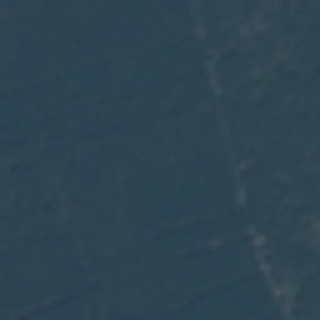

Image:3819 | GT: Forest
1st Pred: Forest (7.291) | 2nd Pred: SeaLake (3.280)


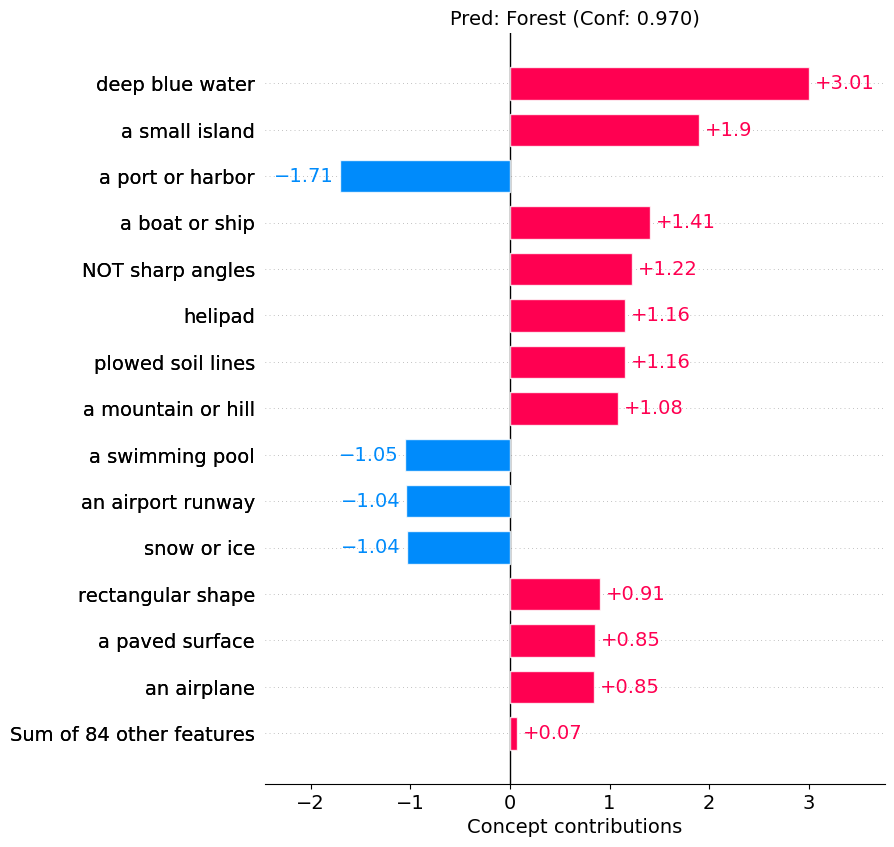

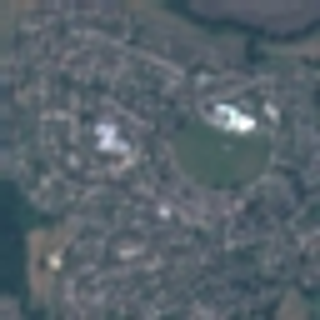

Image:4542 | GT: Residential
1st Pred: Residential (11.820) | 2nd Pred: Industrial (5.874)


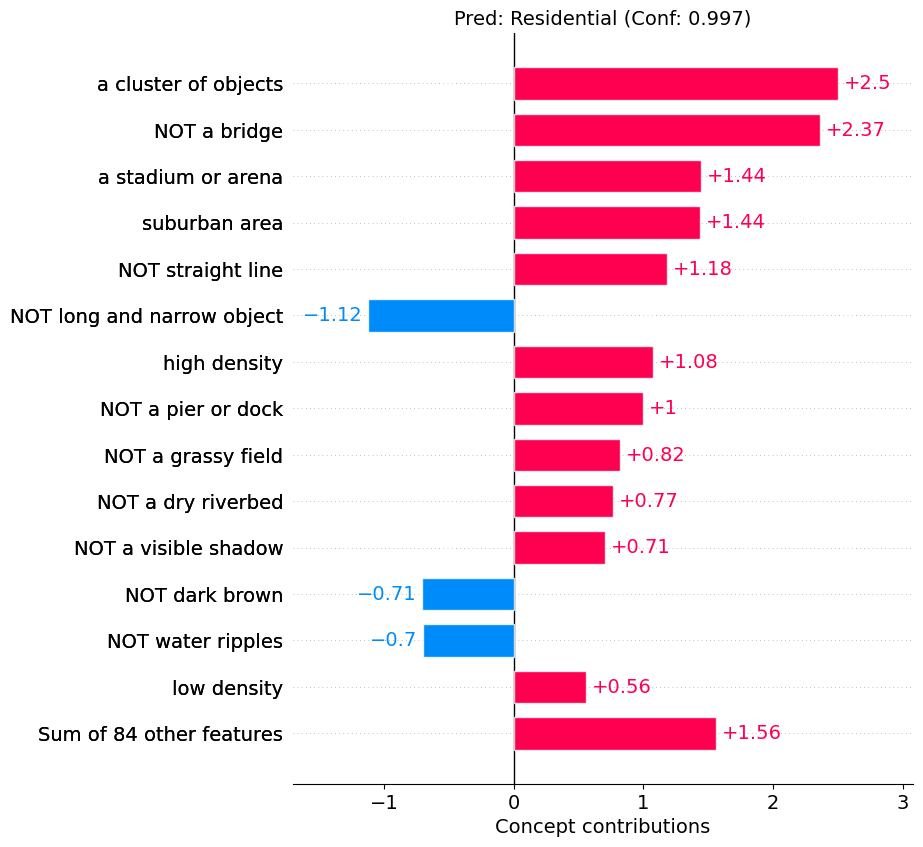

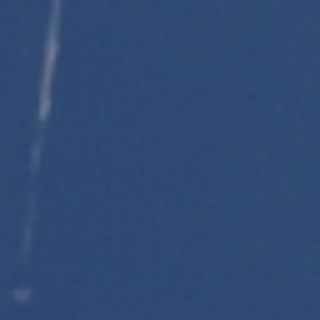

Image:1161 | GT: SeaLake
1st Pred: HerbaceousVegetation (5.521) | 2nd Pred: SeaLake (5.220)


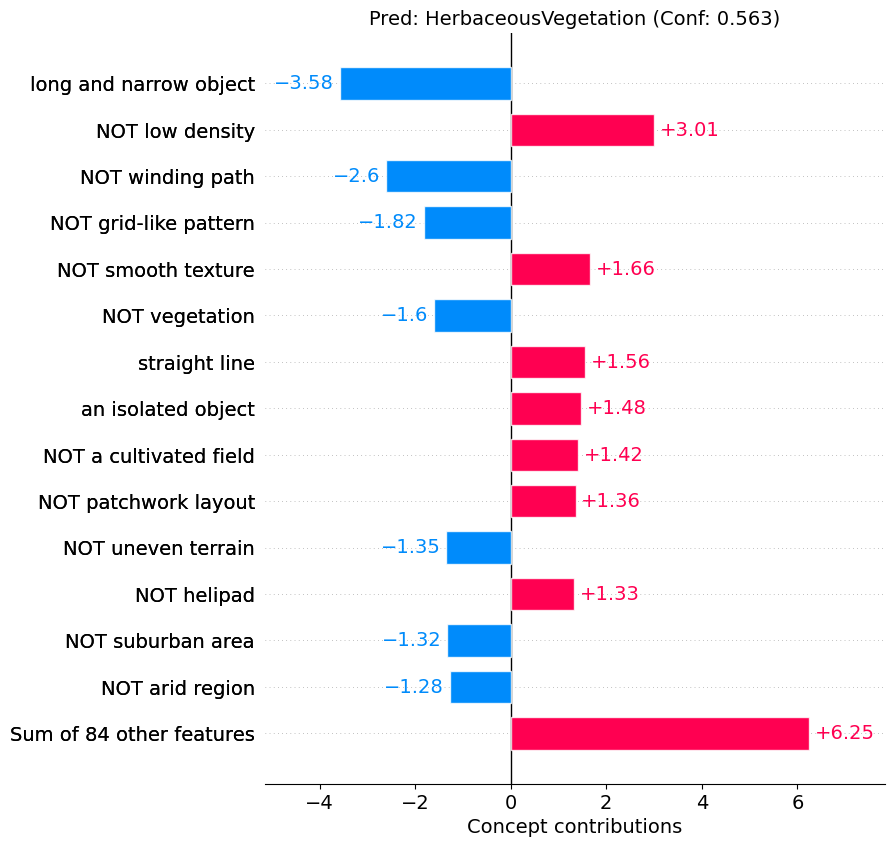

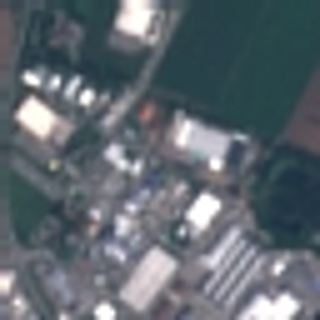

Image:2892 | GT: Industrial
1st Pred: Industrial (9.400) | 2nd Pred: Highway (4.090)


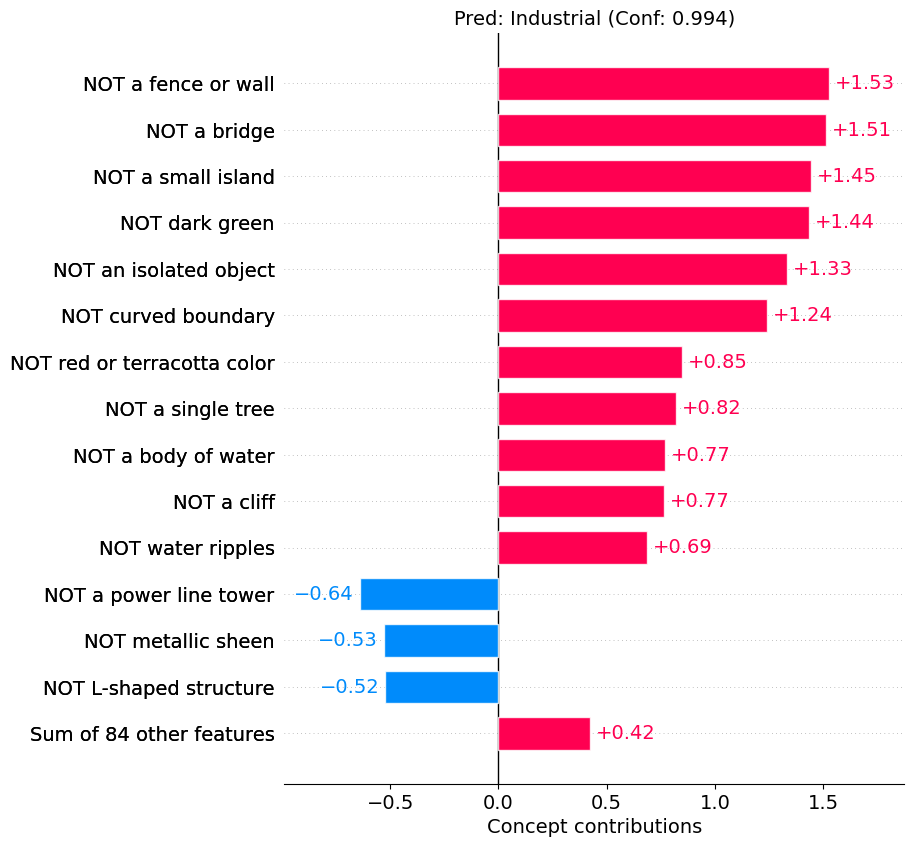

In [ ]:
# 개별 이미지 추론 및 시각화 
print("\n=== Local Explanation (Bar Plots) ===")
# 랜덤으로 4장 뽑아서 시각화
to_display = random.sample([i for i in range(len(val_pil_data))], k=4)

with torch.no_grad():
    for i in to_display:
        image, label = val_pil_data[i]
        x, _ = val_data_t[i]
        x = x.unsqueeze(0).to(device)
        
        display(image.resize([320,320]))
        
        outputs, concept_act = model(x)
        
        # 상위 2개 예측 클래스
        top_logit_vals, top_classes = torch.topk(outputs[0], dim=0, k=2)
        conf = torch.nn.functional.softmax(outputs[0], dim=0)
        
        gt_class = classes[int(label)]
        pred_class_1 = classes[top_classes[0]]
        pred_class_2 = classes[top_classes[1]]
        
        print(f"Image:{i} | GT: {gt_class}")
        print(f"1st Pred: {pred_class_1} ({top_logit_vals[0]:.3f}) | 2nd Pred: {pred_class_2} ({top_logit_vals[1]:.3f})")
        
        # 1순위 예측에 대한 설명 시각화
        for k in range(1): # 가장 높은 예측 하나만 봄
            target_idx = top_classes[k]
            
            contributions = concept_act[0] * model.final.weight[target_idx, :]
            
            values = contributions.cpu().numpy()
            
            # 개념 이름에 "NOT" 붙이기 (concept_act(활성화 값)가 음수(< 0)인 경우 이름 앞에 "NOT")
            # 모델 내부에서 개념 점수는 정규화 되어 있다. (여기 ipynb 말고)
            # 점수가 음수라는 것은 해당 특징이 평균보다 현저히 적거나 없음을 의미
            # (예: 'Water' 점수가 음수 -> 'NOT Water' -> 물이 없다는 사실이 근거가 됨)
            feature_names = [("NOT " if concept_act[0][idx] < 0 else "") + concepts[idx] for idx in range(len(concepts))]
            
            # 그래프 그리기
            max_display = min(int(sum(abs(values)>0.005))+1, 15) # 최대 15개까지 표시
            title = f"Pred: {classes[target_idx]} (Conf: {conf[target_idx]:.3f})"
            
            plots.bar(values, feature_names, max_display=max_display, title=title, fontsize=14)

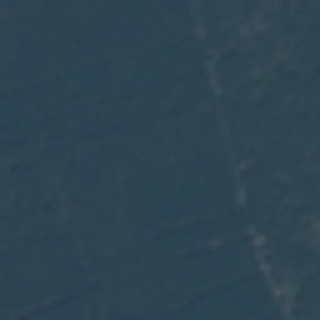

Image:3819 Gt:Forest, 1st Pred:Forest, 7.291, 2nd Pred:SeaLake, 3.280


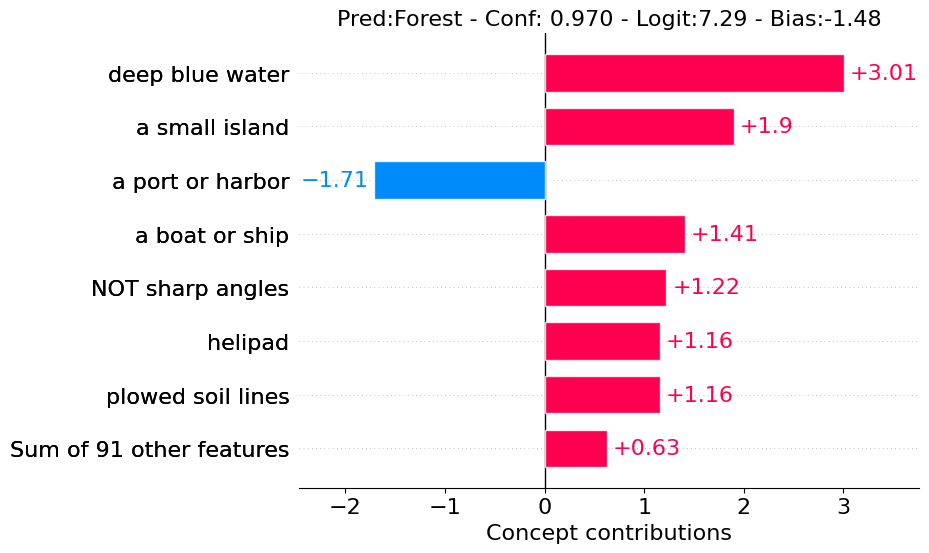

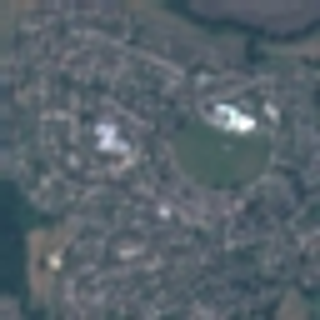

Image:4542 Gt:Residential, 1st Pred:Residential, 11.820, 2nd Pred:Industrial, 5.874


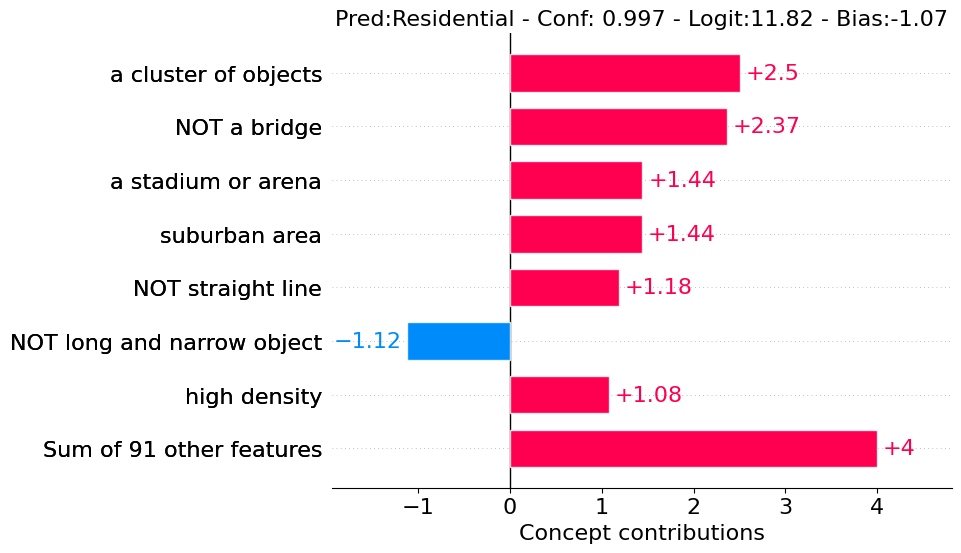

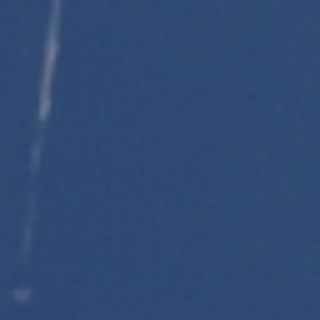

Image:1161 Gt:SeaLake, 1st Pred:HerbaceousVegetation, 5.521, 2nd Pred:SeaLake, 5.220


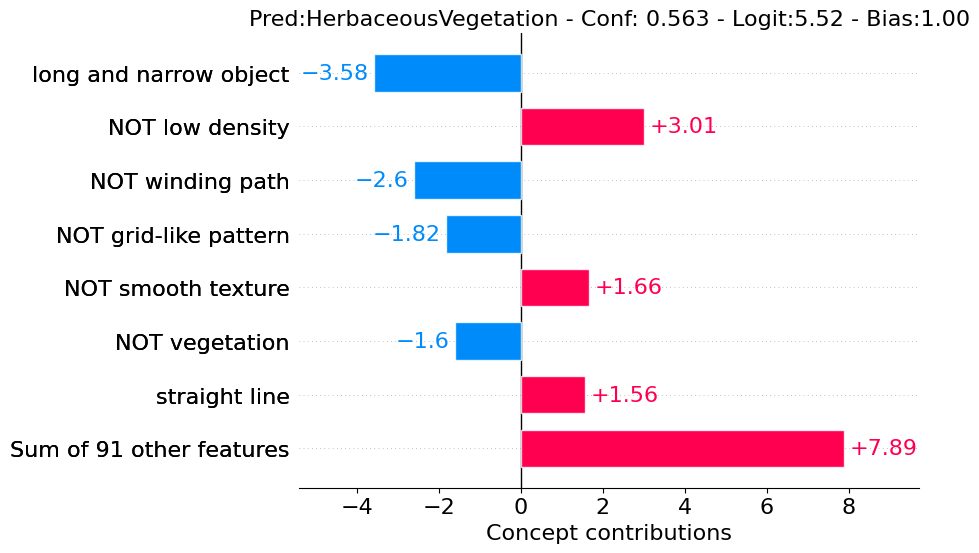

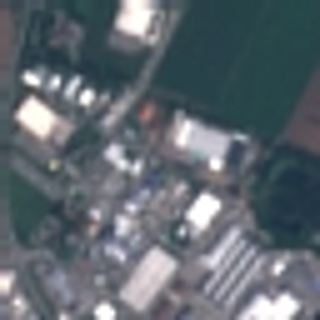

Image:2892 Gt:Industrial, 1st Pred:Industrial, 9.400, 2nd Pred:Highway, 4.090


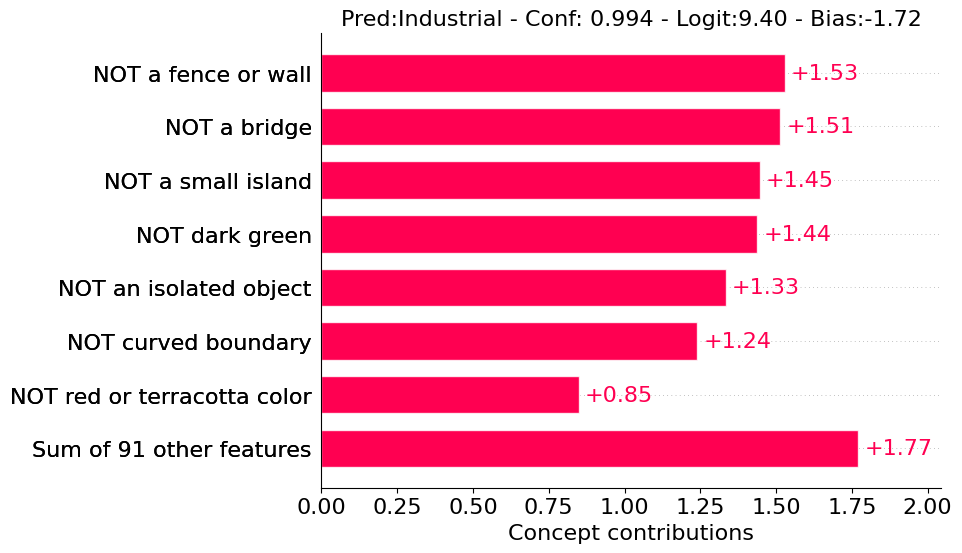

In [ ]:

target_class_name = 'AnnualCrop' # 클래스
num_samples = 20                 # 이미지 수


with torch.no_grad():
    for i in to_display:
        image, label = val_pil_data[i] # 원본 이미지 
        x_tensor, label_tensor = val_data_t[i] 
        x = x_tensor.unsqueeze(0).to(device) # x_tensor 
        display(image.resize([320,320]))

        outputs, concept_act = model(x)

        top_logit_vals, top_classes = torch.topk(outputs[0], dim=0, k=2)
        conf = torch.nn.functional.softmax(outputs[0], dim=0)
        print("Image:{} Gt:{}, 1st Pred:{}, {:.3f}, 2nd Pred:{}, {:.3f}".format(i, classes[int(label_tensor)], classes[top_classes[0]], top_logit_vals[0],
                                                                               classes[top_classes[1]], top_logit_vals[1]))

        for k in range(1):
            contributions = concept_act[0]*model.final.weight[top_classes[k], :]
            feature_names = [("NOT " if concept_act[0][j] < 0 else "") + concepts[j] for j in range(len(concepts))]
            values = contributions.cpu().numpy()
            max_display = min(int(sum(abs(values)>0.005))+1, 8)
            title = "Pred:{} - Conf: {:.3f} - Logit:{:.2f} - Bias:{:.2f}".format(classes[top_classes[k]],
                                                                                 conf[top_classes[k]], top_logit_vals[k], model.final.bias[top_classes[k]])
            plots.bar(values, feature_names, max_display=max_display, title=title, fontsize=16)
# 클래스 선택하고 거기서 아무거나 num_samples 개 이미지

'Residential' 클래스(인덱스: 7)의 첫 20개 샘플을 표시합니다:


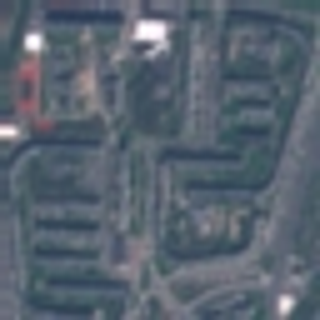

Image:7 Gt:Residential, 1st Pred:Industrial, 8.013, 2nd Pred:Residential, 7.312


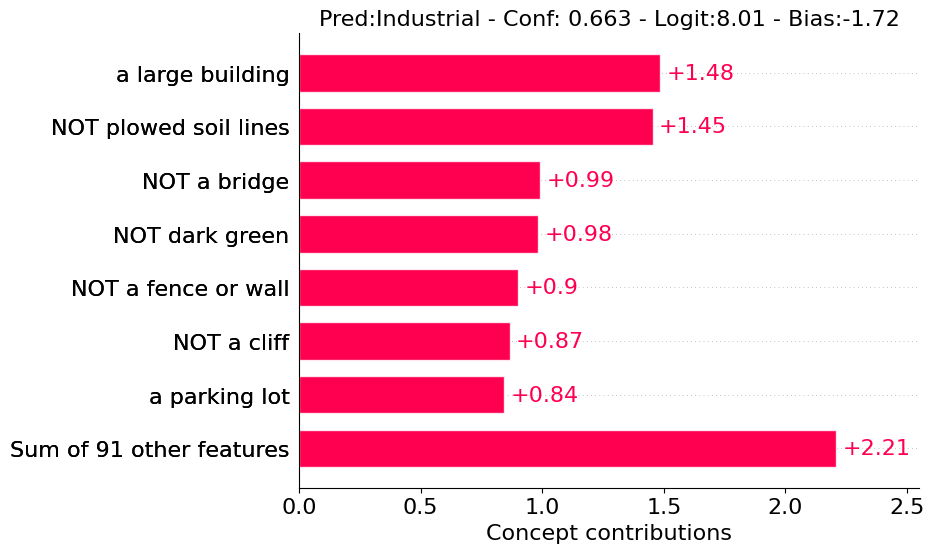

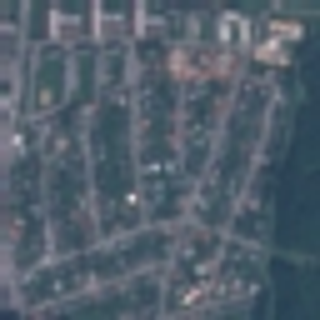

Image:12 Gt:Residential, 1st Pred:Residential, 11.097, 2nd Pred:Industrial, 6.565


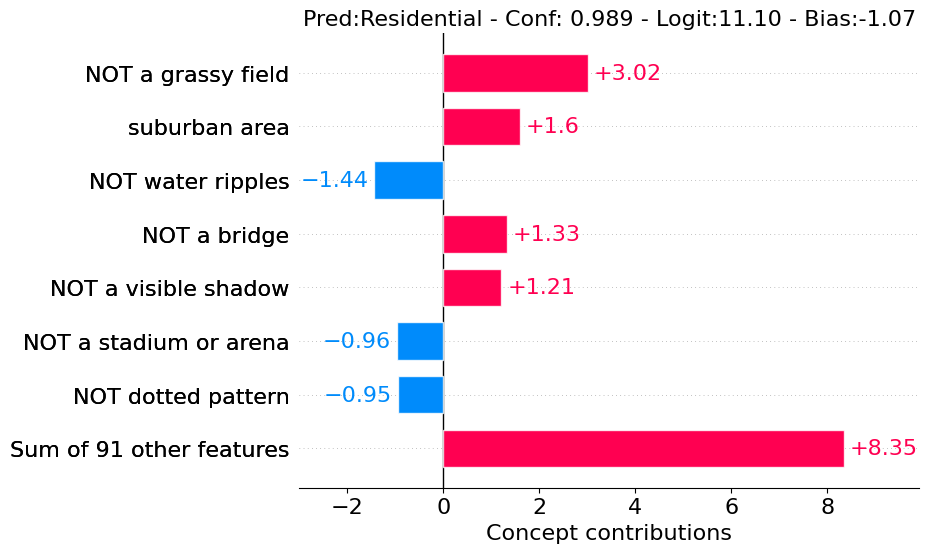

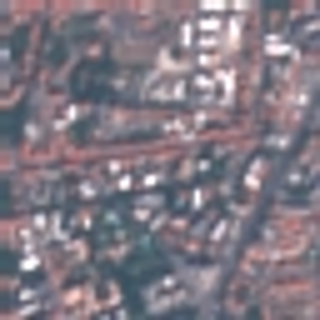

Image:18 Gt:Residential, 1st Pred:Residential, 11.306, 2nd Pred:Industrial, 4.011


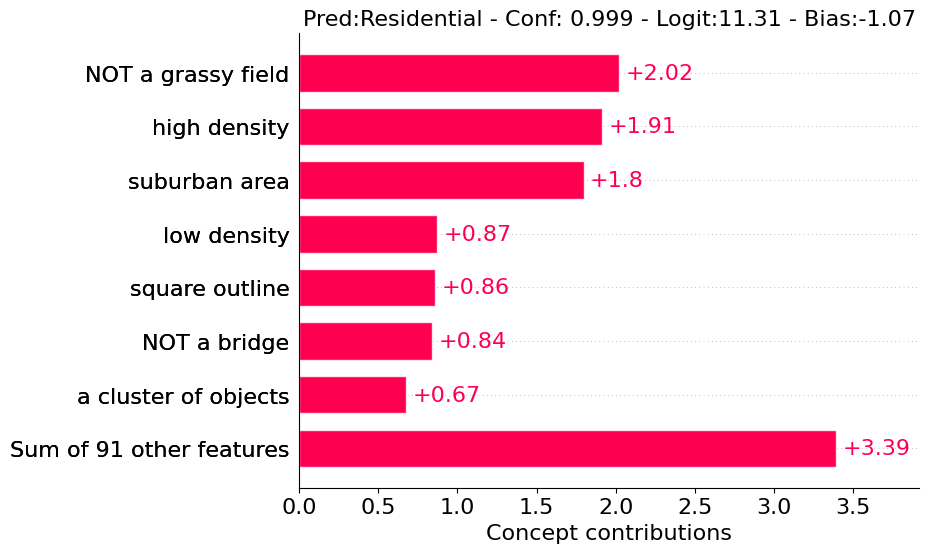

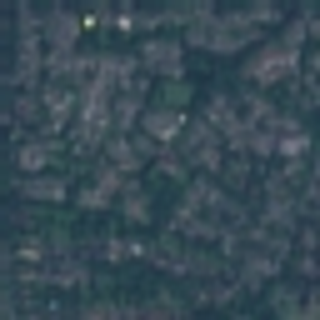

Image:22 Gt:Residential, 1st Pred:Residential, 10.317, 2nd Pred:Industrial, 2.887


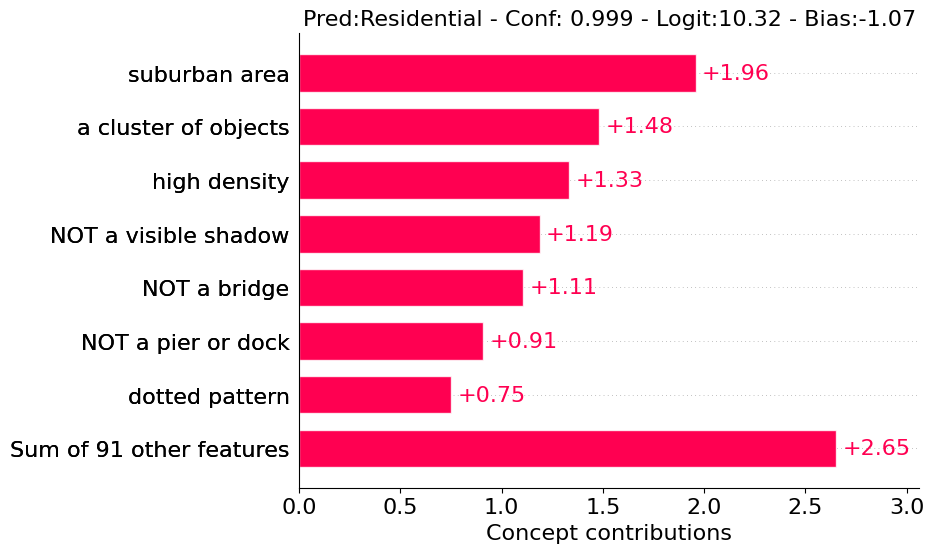

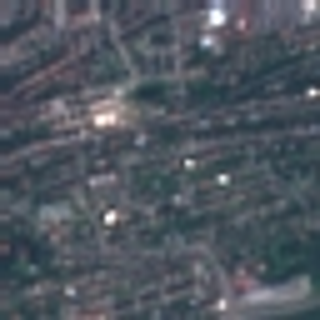

Image:24 Gt:Residential, 1st Pred:Residential, 12.200, 2nd Pred:Industrial, 7.981


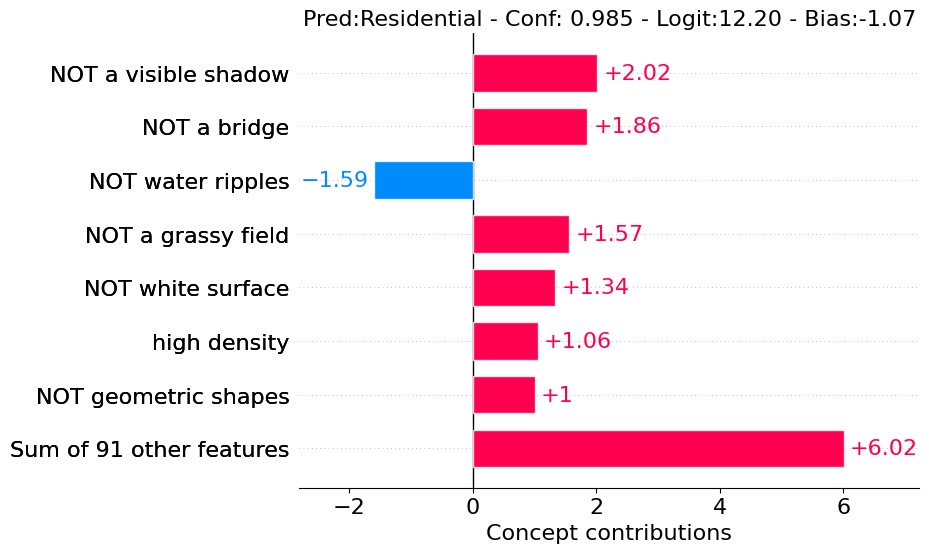

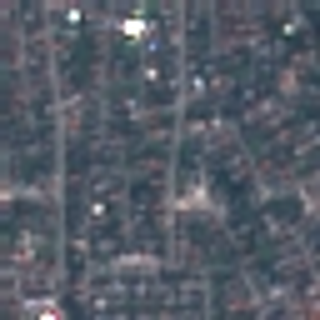

Image:26 Gt:Residential, 1st Pred:Residential, 13.362, 2nd Pred:Industrial, 5.448


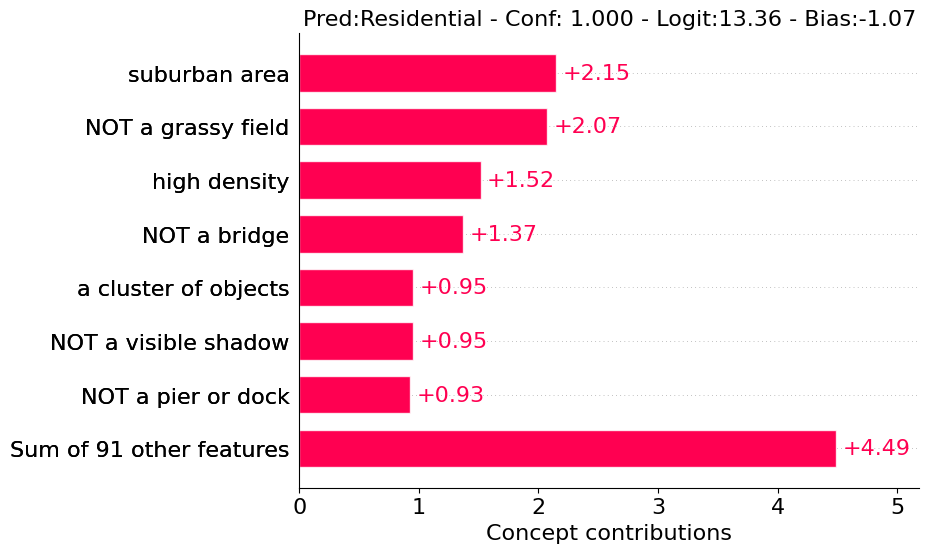

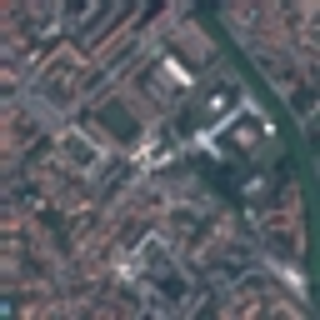

Image:45 Gt:Residential, 1st Pred:Residential, 8.242, 2nd Pred:PermanentCrop, 3.457


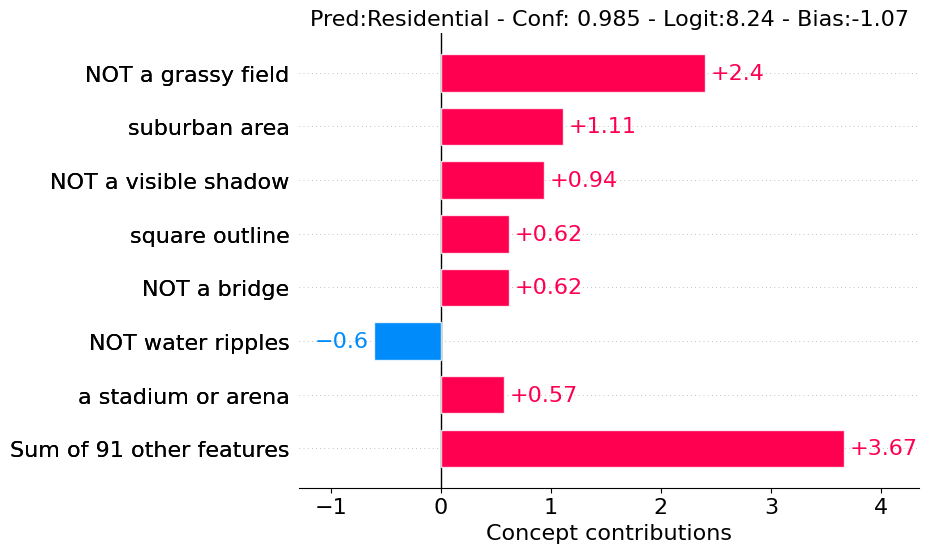

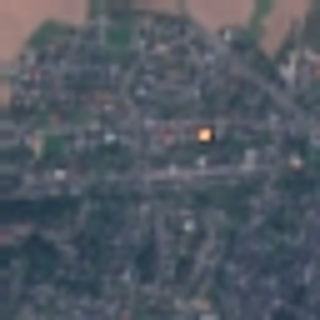

Image:63 Gt:Residential, 1st Pred:Residential, 10.026, 2nd Pred:Industrial, 4.001


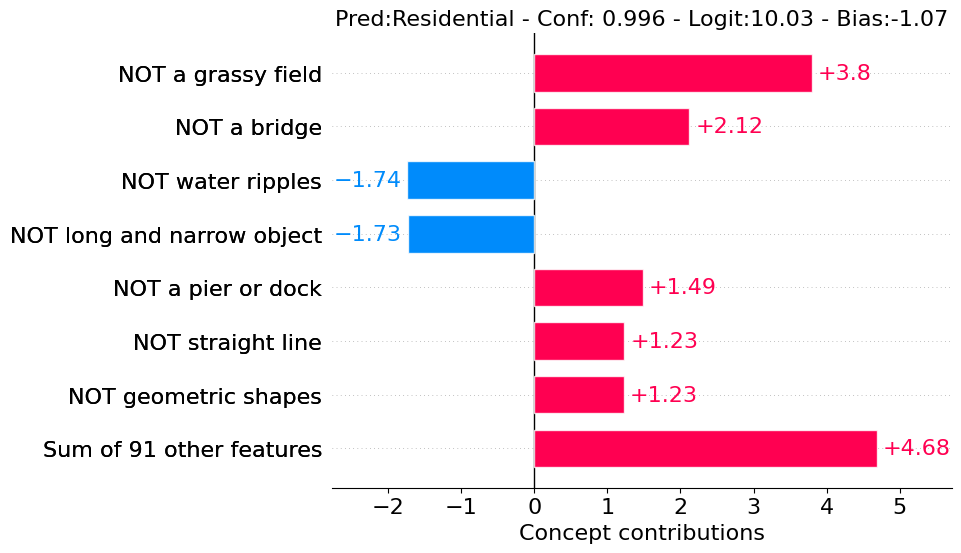

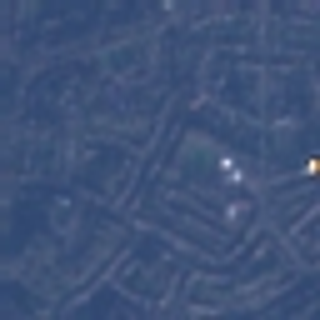

Image:68 Gt:Residential, 1st Pred:Residential, 9.079, 2nd Pred:HerbaceousVegetation, 3.499


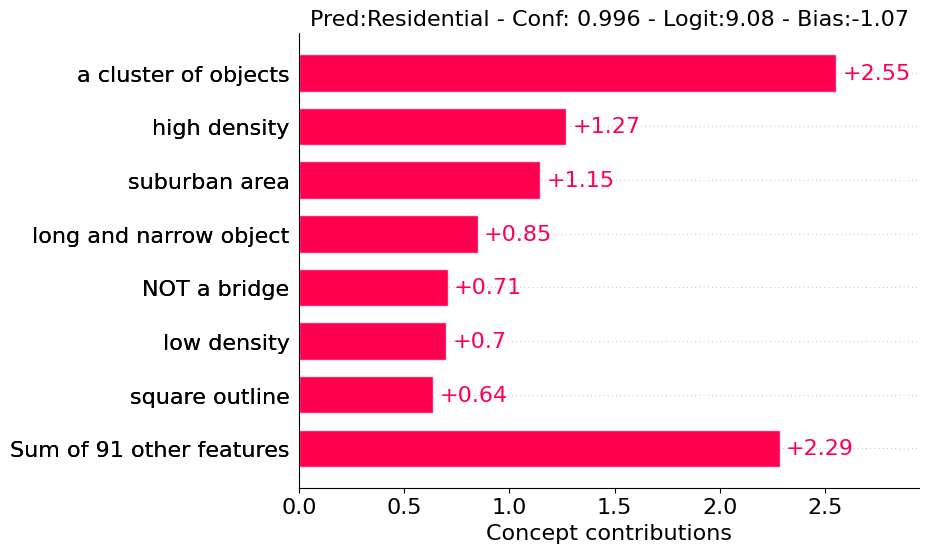

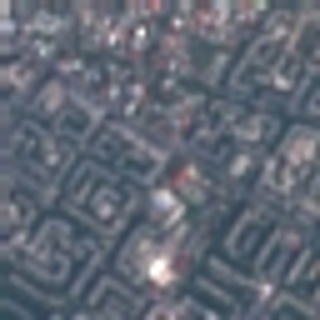

Image:88 Gt:Residential, 1st Pred:Residential, 11.643, 2nd Pred:Industrial, 6.252


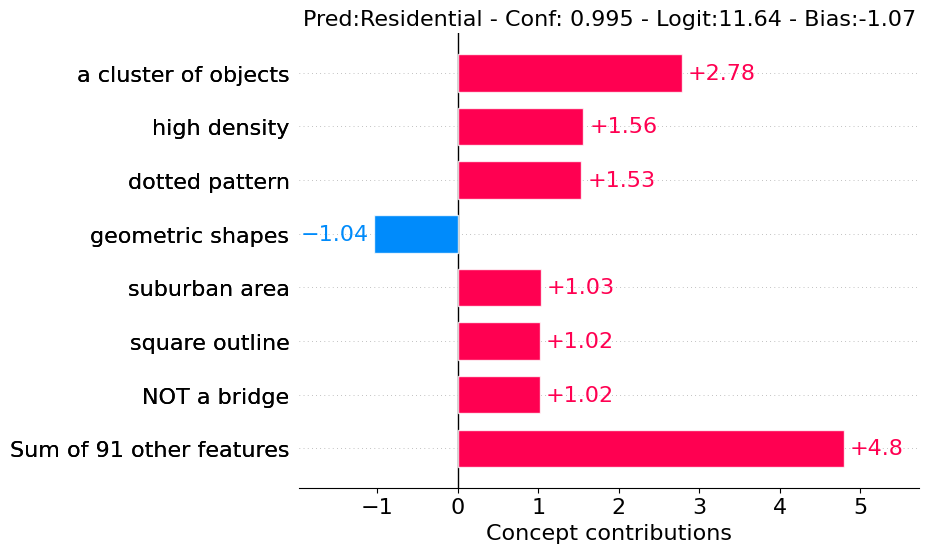

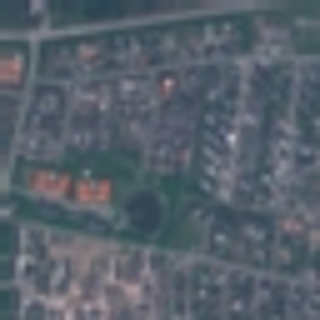

Image:93 Gt:Residential, 1st Pred:Residential, 4.837, 2nd Pred:Industrial, 2.712


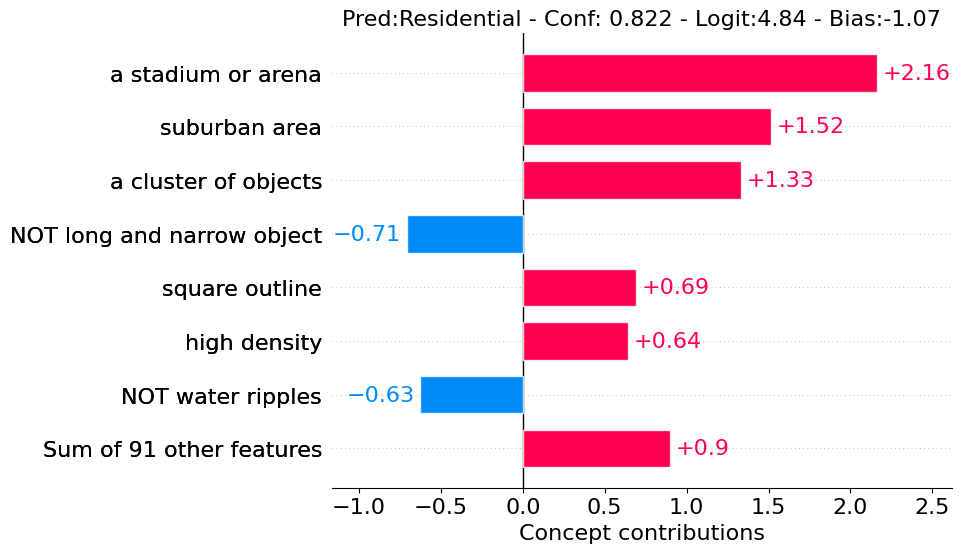

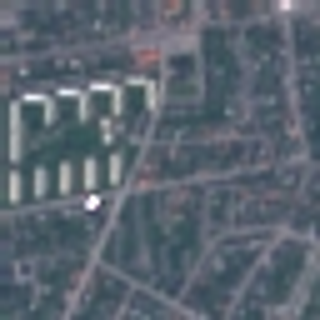

Image:94 Gt:Residential, 1st Pred:Industrial, 8.679, 2nd Pred:Residential, 8.497


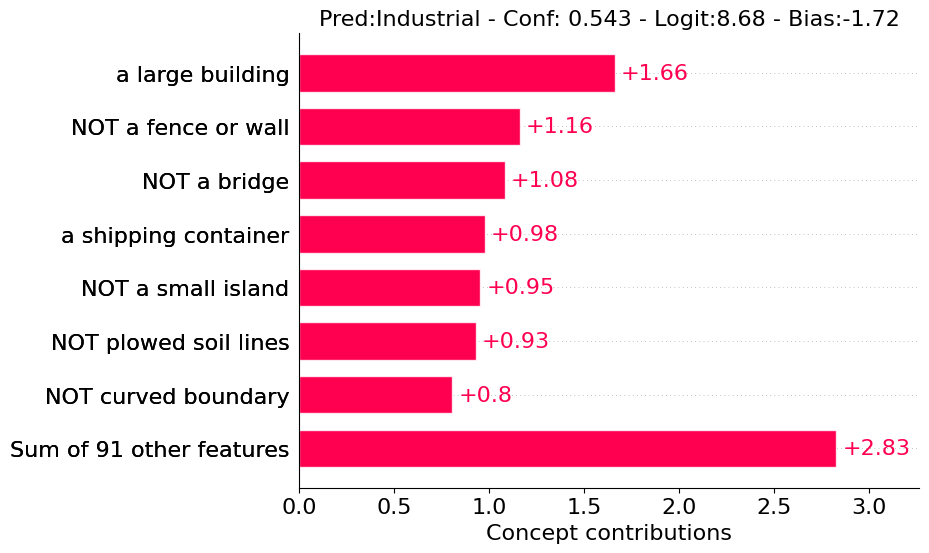

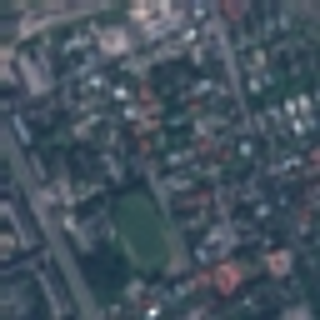

Image:104 Gt:Residential, 1st Pred:Residential, 8.738, 2nd Pred:Industrial, 3.437


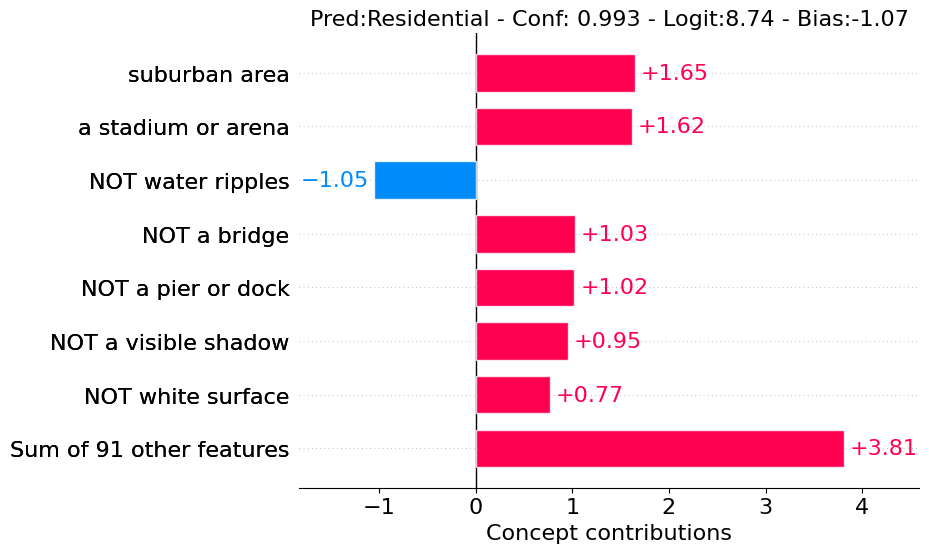

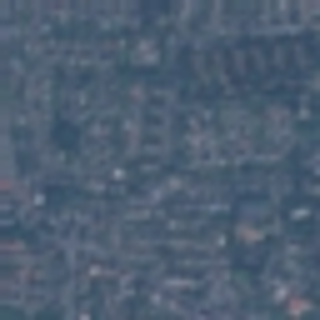

Image:112 Gt:Residential, 1st Pred:Residential, 11.858, 2nd Pred:PermanentCrop, 3.693


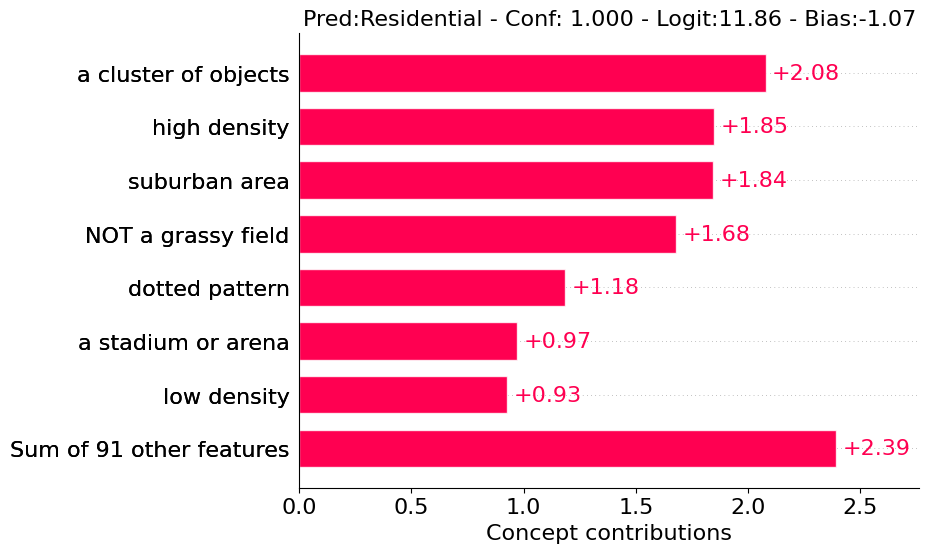

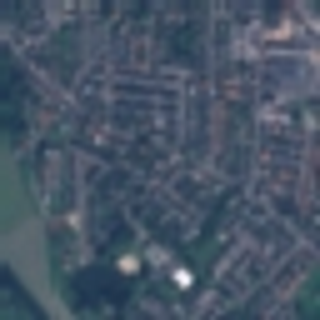

Image:131 Gt:Residential, 1st Pred:Residential, 8.969, 2nd Pred:Highway, 5.098


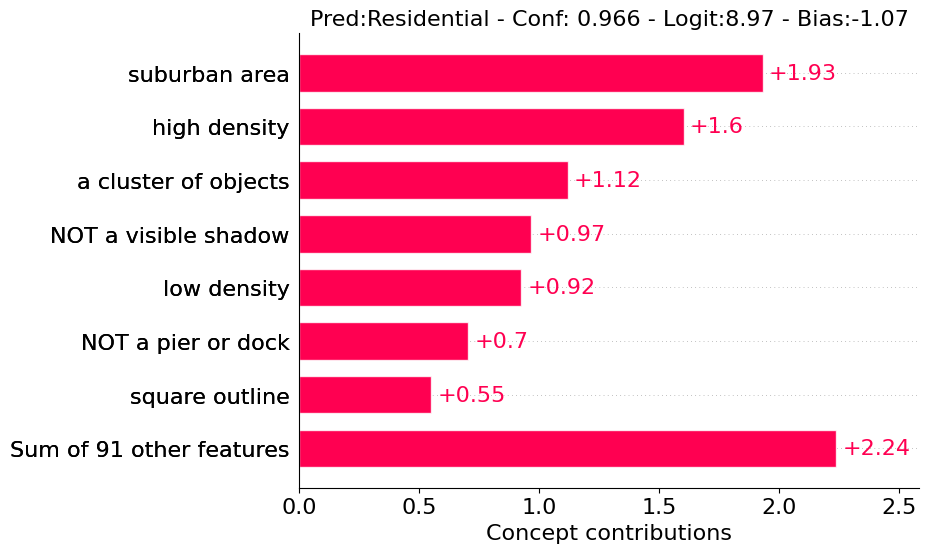

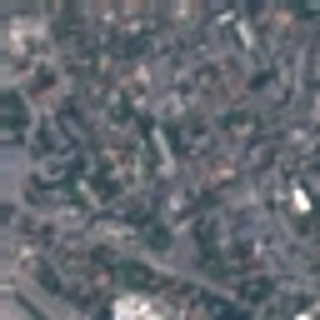

Image:137 Gt:Residential, 1st Pred:Residential, 11.129, 2nd Pred:Industrial, 5.096


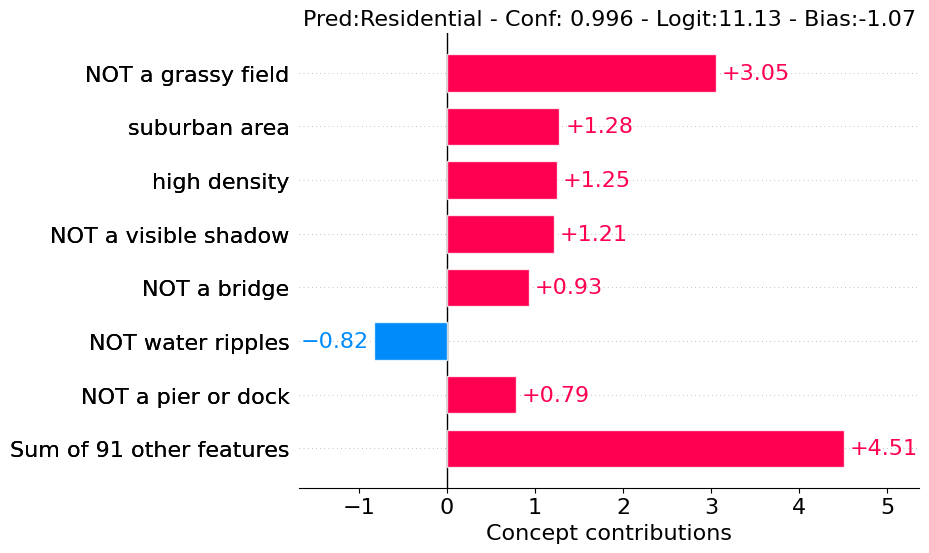

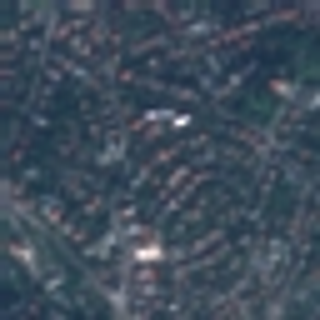

Image:142 Gt:Residential, 1st Pred:Residential, 15.631, 2nd Pred:Industrial, 3.328


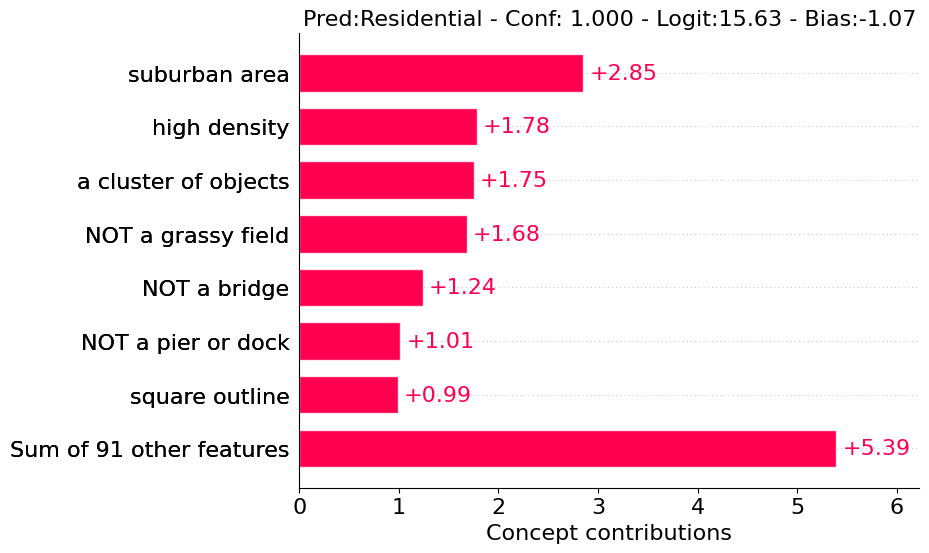

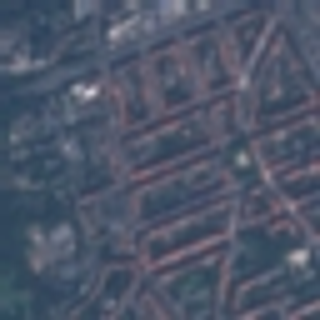

Image:162 Gt:Residential, 1st Pred:Residential, 12.311, 2nd Pred:PermanentCrop, 7.506


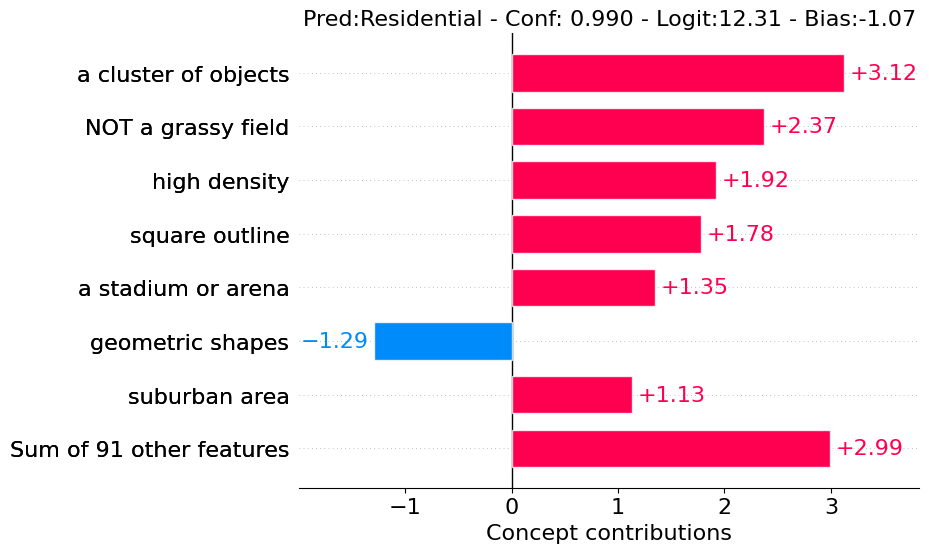

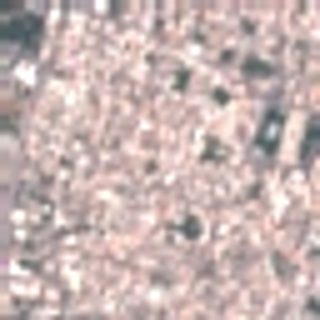

Image:163 Gt:Residential, 1st Pred:Residential, 10.277, 2nd Pred:Industrial, 4.456


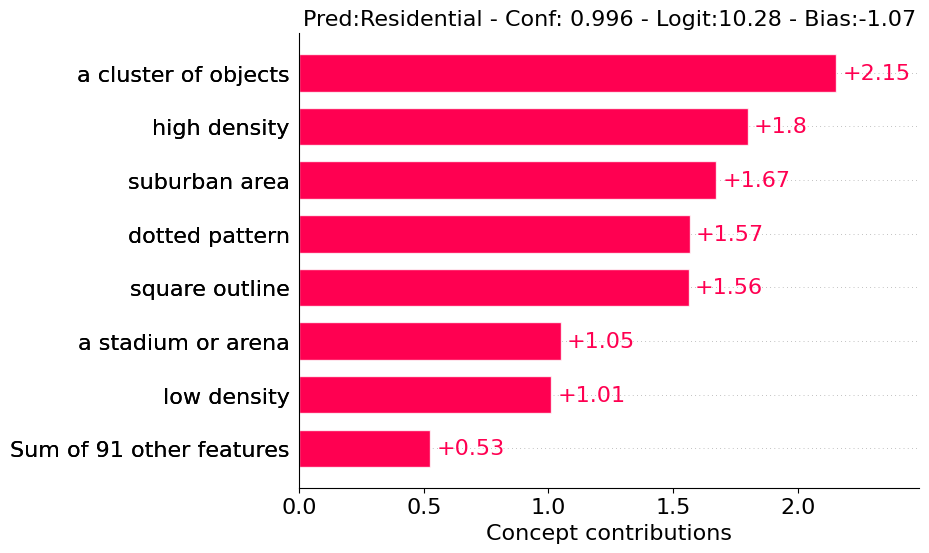

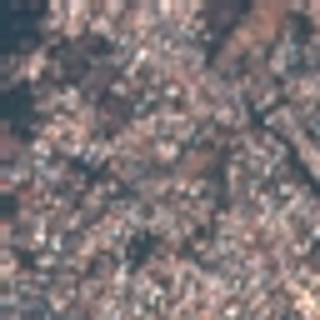

Image:166 Gt:Residential, 1st Pred:Residential, 12.034, 2nd Pred:Industrial, 3.695


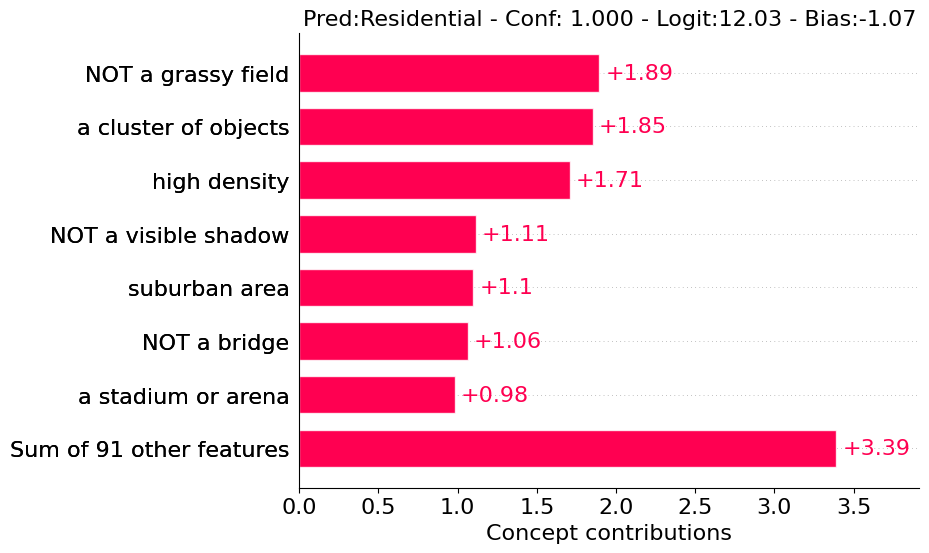

In [ ]:

target_class_name = 'Residential'
num_samples = 20                

target_label_index = classes.index(target_class_name)
target_indices = [i for i, (_, label) in enumerate(val_data_t) if int(label) == target_label_index]

num_samples_to_draw = min(num_samples, len(target_indices)) 
to_display = target_indices[:num_samples_to_draw] # 랜덤으로 뽑지말고 앞에서 부터 뽑기 

# 위의 셀의 코드 유지
with torch.no_grad():
    for i in to_display:
        image, label = val_pil_data[i] # 원본 이미지 로딩
        x_tensor, label_tensor = val_data_t[i] 
        x = x_tensor.unsqueeze(0).to(device) # x_tensor 사용
        display(image.resize([320,320]))

        outputs, concept_act = model(x)

        top_logit_vals, top_classes = torch.topk(outputs[0], dim=0, k=2)
        conf = torch.nn.functional.softmax(outputs[0], dim=0)
        print("Image:{} Gt:{}, 1st Pred:{}, {:.3f}, 2nd Pred:{}, {:.3f}".format(i, classes[int(label_tensor)], classes[top_classes[0]], top_logit_vals[0],
                                                                               classes[top_classes[1]], top_logit_vals[1]))

        for k in range(1):
            contributions = concept_act[0]*model.final.weight[top_classes[k], :]
            feature_names = [("NOT " if concept_act[0][j] < 0 else "") + concepts[j] for j in range(len(concepts))]
            values = contributions.cpu().numpy()
            max_display = min(int(sum(abs(values)>0.005))+1, 8)
            title = "Pred:{} - Conf: {:.3f} - Logit:{:.2f} - Bias:{:.2f}".format(classes[top_classes[k]],
                                                                                 conf[top_classes[k]], top_logit_vals[k], model.final.bias[top_classes[k]])
            plots.bar(values, feature_names, max_display=max_display, title=title, fontsize=16)